In [2]:
import pandas as pd
import numpy as np

from keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate
from keras.models import Model

In [3]:
df = pd.read_csv("ratings.csv")
df.shape

(981756, 3)

In [4]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2, random_state=42)

In [5]:
train.head()

,book_id,user_id,rating
341848,3423,4608,2
964349,9811,36373,5
645459,6485,2957,4
74960,750,42400,3
358670,3591,36886,5


In [6]:
test.head()

,book_id,user_id,rating
646451,6495,19643,5
614851,6175,8563,4
974393,9920,52110,3
21471,215,33864,5
272540,2728,16587,3


In [7]:
users = len(df.user_id.unique())
users

53424

In [8]:
books = len(df.book_id.unique())
books

10000

In [9]:
book_input = Input(shape=[1], name="Book-Input")
book_embedding = Embedding(books+1, 5, name="Book-Embedding")(book_input)
book_vec = Flatten(name="Flatten-Books")(book_embedding)

user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(users+1, 5, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

prod = Dot(name="Dot-Product", axes=1)([book_vec, user_vec])
model = Model([user_input, book_input], prod)
model.compile('adam', 'mean_squared_error')

In [10]:
model.evaluate([test.user_id, test.book_id], test.rating)

6136/6136 [==============================] - 11s 2ms/step - loss: 15.8283


15.82831859588623

In [11]:
predictions = model.predict([test.user_id.head(10), test.book_id.head(10)])

1/1 [==============================] - 0s 275ms/step


In [12]:
for i in range(0,10):
   print(predictions[i], test.rating.iloc[i]) 

[-0.00078244] 5
[-0.00088003] 4
[-0.00227096] 3
[-0.00036193] 5
[-0.00041394] 3
[0.00239061] 3
[-0.00115137] 3
[0.00186211] 4
[0.00271521] 3
[-0.00244915] 5


Visualizing Embeddings

In [13]:
book_em = model.get_layer('Book-Embedding')
book_em_weights = book_em.get_weights()[0]

In [14]:
book_em_weights[:5]

array([[-0.01531956, -0.04763166,  0.03634704,  0.02693731, -0.04661191],
       [ 0.03427568, -0.03032626,  0.04935456,  0.01724971, -0.01517264],
       [ 0.03576136,  0.01397947,  0.03350447, -0.03359443,  0.02147429],
       [ 0.01966153,  0.00443019, -0.04611271, -0.01256005,  0.04972572],
       [-0.04138893, -0.04613986,  0.01812435, -0.00275248, -0.04139224]],
      dtype=float32)

<Axes: >

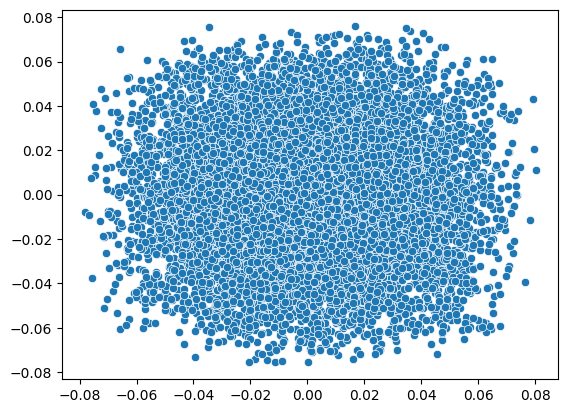

In [15]:
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2)
pca_result = pca.fit_transform(book_em_weights)
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1])

In [16]:
book_em_weights = book_em_weights / np.linalg.norm(book_em_weights, axis = 1).reshape((-1, 1))
book_em_weights[0][:10]
np.sum(np.square(book_em_weights[0]))

1.0

<Axes: >

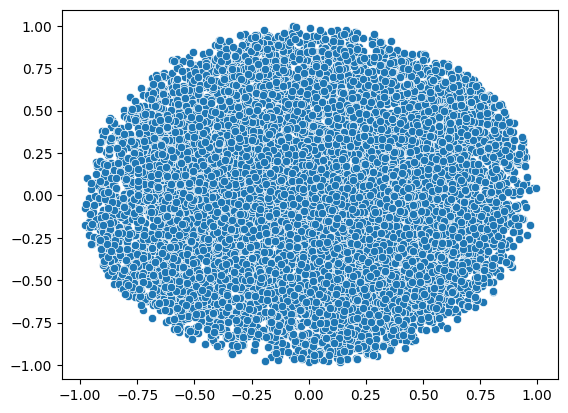

In [17]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(book_em_weights)
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1])

In [18]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tnse_results = tsne.fit_transform(book_em_weights)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10001 samples in 0.008s...
[t-SNE] Computed neighbors for 10001 samples in 0.463s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10001
[t-SNE] Computed conditional probabilities for sample 2000 / 10001
[t-SNE] Computed conditional probabilities for sample 3000 / 10001
[t-SNE] Computed conditional probabilities for sample 4000 / 10001
[t-SNE] Computed conditional probabilities for sample 5000 / 10001
[t-SNE] Computed conditional probabilities for sample 6000 / 10001
[t-SNE] Computed conditional probabilities for sample 7000 / 10001
[t-SNE] Computed conditional probabilities for sample 8000 / 10001
[t-SNE] Computed conditional probabilities for sample 9000 / 10001
[t-SNE] Computed conditional probabilities for sample 10000 / 10001
[t-SNE] Computed conditional probabilities for sample 10001 / 10001
[t-SNE] Mean sigma: 0.187782


c:\users\ferhat\desktop\python\ml exercies\venv\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\users\ferhat\desktop\python\ml exercies\venv\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


[t-SNE] KL divergence after 250 iterations with early exaggeration: 89.253441
[t-SNE] KL divergence after 300 iterations: 3.098254


<Axes: >

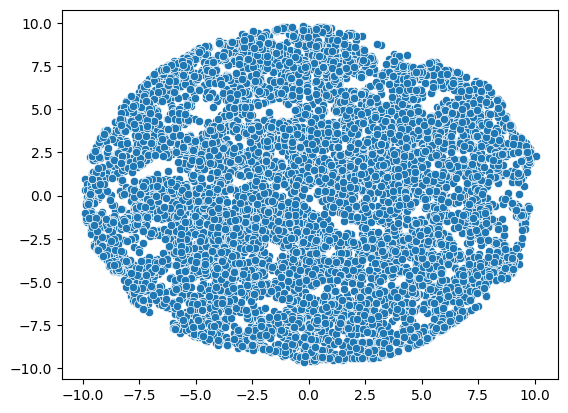

In [19]:
sns.scatterplot(x=tnse_results[:,0], y=tnse_results[:,1])

Making Recommendations

In [20]:
book_data = np.array(list(set(df.book_id)))
book_data[:5]

array([1, 2, 3, 4, 5])

In [21]:
user = np.array([1 for i in range(len(book_data))])
user[:5]

array([1, 1, 1, 1, 1])

In [22]:
predictions = model.predict([user, book_data])
predictions = np.array([a[0] for a in predictions])

recommended_book_ids = (-predictions).argsort()[:5]
recommended_book_ids

313/313 [==============================] - 1s 2ms/step


array([7901,  655, 8375, 2253, 3586], dtype=int64)

In [23]:
books = pd.read_csv("books.csv")

In [24]:
books[books["id"].isin(recommended_book_ids)]

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
654,655,15812814,15812814,14449475,63,142421715,9.780142e+12,Ally Condie,2011.0,Crossed,...,100886,179584,14020,6581,22713,57856,55935,36499,https://images.gr-assets.com/books/1374335939m...,https://images.gr-assets.com/books/1374335939s...
2252,2253,39020,39020,38742,37,1400032059,9.781400e+12,Charles C. Mann,2005.0,1491: New Revelations of the Americas Before C...,...,41815,43649,2811,1186,2008,8065,16264,16126,https://images.gr-assets.com/books/1327865228m...,https://images.gr-assets.com/books/1327865228s...
3585,3586,1237300,1237300,2826418,67,805079831,9.780805e+12,Naomi Klein,2006.0,The Shock Doctrine: The Rise of Disaster Capit...,...,24111,27056,2120,448,929,3616,9230,12833,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...
7900,7901,21437200,21437200,40747882,12,080417072X,9.780804e+12,"Rob Thomas, Jennifer Graham",2015.0,Mr. Kiss and Tell,...,12729,15011,1836,58,324,3225,7201,4203,https://images.gr-assets.com/books/1405566768m...,https://images.gr-assets.com/books/1405566768s...
8374,8375,2068,2068,1835,24,068482471X,9.780685e+12,Daniel C. Dennett,1995.0,Darwin's Dangerous Idea: Evolution and the Mea...,...,11090,11292,222,276,592,2164,3717,4543,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...


In [25]:
books[books["id"].isin(recommended_book_ids)].set_index("original_title")

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
original_title,,,,,,,,,,,,,,,,,,,,,
Crossed,655,15812814,15812814,14449475,63,142421715,9.780142e+12,Ally Condie,2011.0,"Crossed (Matched, #2)",...,100886,179584,14020,6581,22713,57856,55935,36499,https://images.gr-assets.com/books/1374335939m...,https://images.gr-assets.com/books/1374335939s...
1491: New Revelations of the Americas Before Columbus,2253,39020,39020,38742,37,1400032059,9.781400e+12,Charles C. Mann,2005.0,1491: New Revelations of the Americas Before C...,...,41815,43649,2811,1186,2008,8065,16264,16126,https://images.gr-assets.com/books/1327865228m...,https://images.gr-assets.com/books/1327865228s...
The Shock Doctrine: The Rise of Disaster Capitalism,3586,1237300,1237300,2826418,67,805079831,9.780805e+12,Naomi Klein,2006.0,The Shock Doctrine: The Rise of Disaster Capit...,...,24111,27056,2120,448,929,3616,9230,12833,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...
Mr. Kiss and Tell,7901,21437200,21437200,40747882,12,080417072X,9.780804e+12,"Rob Thomas, Jennifer Graham",2015.0,"Mr. Kiss and Tell (Veronica Mars, #2)",...,12729,15011,1836,58,324,3225,7201,4203,https://images.gr-assets.com/books/1405566768m...,https://images.gr-assets.com/books/1405566768s...
Darwin's Dangerous Idea: Evolution and the Meanings of Life,8375,2068,2068,1835,24,068482471X,9.780685e+12,Daniel C. Dennett,1995.0,Darwin's Dangerous Idea: Evolution and the Mea...,...,11090,11292,222,276,592,2164,3717,4543,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...
